# Compare two 3D arrays

In [ ]:
import numpy as np
x=3; y=4; z=5
a = np.random.randint(0, 10, size=(x,y,z))
b = np.random.randint(0, 10, size=(x,y,z))

## compare constants

In [ ]:
import nnabla as nn

nn.set_auto_forward(True)

x0 = nn.NdArray((a.shape))
x0.data = a
x1 = nn.NdArray((b.shape))
x1.data = b
print("x0=", x0.data)
print("x1=", x1.data)

In [ ]:
r = nn.functions.equal(x0, x1, n_outputs=-1, outputs=None)
print(r, r.data)

In [ ]:
r = nn.functions.greater(x0, x1, n_outputs=-1, outputs=None)
print(r, r.data)

## compare variables

In [ ]:
x2 = nn.Variable(x0.shape)
x2.data = x0
x3 = nn.Variable(x1.shape)
x3.data = x1

In [ ]:
r = nn.functions.greater(x2, x3, n_outputs=-1, outputs=None)
print(r, r.d)

## minimum

In [ ]:
import nnabla.functions as F

x = nn.Variable.from_numpy_array(np.random.rand(2, 3, 4))
print(x)
print(x.d)

minval = F.min(x, axis=1)
print(minval)
print(minval.d)

## function relu

In [ ]:
import nnabla.parametric_functions as PF
import nnabla.functions as F

x = nn.Variable((2, 3, 8, 8))
x.d = np.random.random(x.shape)  # random input, just for example.

nn.parameter.clear_parameters()
with nn.parameter_scope('conv1') as param:
    conv_out = PF.convolution(x, 2, (5, 5))
    relu_out = F.relu(conv_out)
    
print(relu_out)
print(relu_out.d)

## sigmoid

In [ ]:

import nnabla.parametric_functions as PF
import nnabla.functions as F

x = nn.Variable((2, 3, 8, 8))
x.d = np.random.random(x.shape)  # random input, just for example.

nn.parameter.clear_parameters()
with nn.parameter_scope('conv2') as param:
    conv_out = PF.convolution(x, 2, (5, 5))
    sig_out = F.sigmoid(conv_out)
    
print(sig_out)
print(sig_out.d)

# Parametric functions

## Affine

In [ ]:
import numpy as np
import nnabla as nn
import nnabla.parametric_functions as PF

x = nn.Variable.from_numpy_array(np.array([[1, 2], [3, 4]]))
y = PF.affine(x, 4, name="y")
print("x")
print(x.d)
print("y")
print(y.d)

# Simple CNN

In [ ]:
import nnabla as nn
import nnabla.functions as F
import nnabla.parametric_functions as PF
import numpy as np
import nnabla.initializer as I

nn.parameter.clear_parameters()

rng = np.random.seed(31024)
initializer = I.UniformInitializer((-0.1, 0.1), rng=rng)

# create 16 random images 256x256 (RGB)
x = nn.Variable((16, 3, 256, 256))
x.d = np.random.random(x.shape)  # random input, just for example.

y0 = PF.convolution(x, outmaps=64, kernel=(3, 3), pad=(1, 1), stride=(2, 2), w_init=initializer, name="conv1", with_bias=False)
y1 = F.relu(y0)
y2 = PF.convolution(y1, outmaps=128, kernel=(3, 3), pad=(1, 1), stride=(2, 2), w_init=initializer, name="conv2", with_bias=False)
y3 = F.relu(y2)
y4 = F.average_pooling(y3, kernel=y3.shape[2:])
y5 = PF.affine(y4, 1, w_init=initializer)
loss = F.mean(F.abs(y5 - 1.))
loss.forward()  # Execute forward

# We can check the current gradient of parameter.
print("******* forward *******")
print(nn.get_parameters()["conv1/conv/W"].g)

loss.backward()
print("******* backward *******")
print(nn.get_parameters()["conv1/conv/W"].g)

## CNN with static graph
In this section, we demonstrate:
 - building a simple graph
 - training model
 - running prediction (with the trained model)
 - saving trained model
 - loading trained model
 - running prediction (with the loaded model)

In [92]:
import sys
import numpy as np
from sklearn.datasets import load_digits  # Only for dataset

import nnabla as nn
import nnabla.functions as F
import nnabla.parametric_functions as PF
import nnabla.solvers as S
import nnabla.initializer as I
from nnabla.monitor import tile_images
from nnabla.utils.data_iterator import data_iterator_simple

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

nn.clear_parameters()
nn.reset_array_preference()

# set graph
CNN_GRAPH = 1

batch_size = 64
h5_file_name = 'static_graph.h5'
nnp_file_name = 'cnn_static_graph.nnp'
nnb_file_name = 'cnn_static_graph.nnb'

rng = np.random.seed(31024)
initializer = I.UniformInitializer((-0.1, 0.1), rng=rng)

imshow_opt = dict(cmap='gray', interpolation='nearest')

In [93]:
imshow_opt = dict(cmap='gray', interpolation='nearest')

def plot_stats(digits):
    print("Num images:", digits.images.shape[0])
    print("Image shape:", digits.images.shape[1:])
    print("Labels:", digits.target[:10])
    plt.imshow(tile_images(digits.images[:batch_size, None]), **imshow_opt)


def data_iterator_tiny_digits(digits, batch_size=batch_size, shuffle=False, rng=None):
    def load_func(index):
        """Loading an image and its label"""
        img = digits.images[index]
        label = digits.target[index]
        return img[None], np.array([label]).astype(np.int32)
    return data_iterator_simple(load_func, digits.target.shape[0], batch_size, shuffle, rng, with_file_cache=False)

<class 'sklearn.utils.Bunch'>
Num images: 1797
Image shape: (8, 8)
Labels: [0 1 2 3 4 5 6 7 8 9]


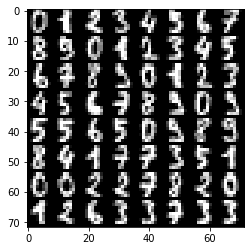

In [97]:
# get dataset
digits = load_digits(n_class=10)
print(type(digits))
plot_stats(digits)

2020-04-20 10:31:54,371 [nnabla][INFO]: DataSource with shuffle(True)
2020-04-20 10:31:54,374 [nnabla][INFO]: Using DataSourceWithMemoryCache
2020-04-20 10:31:54,374 [nnabla][INFO]: DataSource with shuffle(True)
2020-04-20 10:31:54,375 [nnabla][INFO]: On-memory
2020-04-20 10:31:54,376 [nnabla][INFO]: Using DataIterator


labels: [[5 9 7 4 5 7 0 8]
 [1 6 1 7 4 5 8 8]
 [3 3 1 7 1 6 7 9]
 [7 1 3 6 3 6 6 3]
 [7 8 0 1 5 5 4 6]
 [0 5 5 0 8 9 7 8]
 [3 9 8 5 9 7 4 6]
 [8 2 7 6 7 2 3 6]]
Label shape: (64, 1)


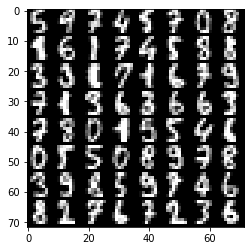

In [73]:
data = data_iterator_tiny_digits(digits, batch_size=batch_size, shuffle=True)
img, label = data.next()
plt.imshow(tile_images(img), **imshow_opt)
print("labels:", label.reshape(8, 8))
print("Label shape:", label.shape)

### build a graph
> Note: we have to run only one section:
    - build simple graph
    - build more complex graph

#### build simple graph

In [74]:
if CNN_GRAPH == 0:
    # Forward pass
    x = nn.Variable(img.shape)  # Define an image variable
    with nn.parameter_scope("affine1"):
        y = PF.affine(x, 10)  # Output is 10 class

    # Building a loss graph
    t = nn.Variable(label.shape)  # Define an target variable
    loss = F.mean(F.softmax_cross_entropy(y, t))  # Softmax Xentropy fits multi-class classification problems

    print("Printing shapes of variables")
    print('x:', x.shape)
    print('y:', y.shape)
    print('t:', t.shape)
    print('loss:', loss.shape)  # empty tuple means scalar

#### build more complex graph

In [75]:
if CNN_GRAPH == 1:
    # Forward pass
    x = nn.Variable(img.shape)  # Define an image variable
    with nn.parameter_scope("affine1"):
        y0 = PF.convolution(x, outmaps=batch_size, kernel=(3, 3), pad=(1, 1), stride=(2, 2), w_init=initializer, name="conv1", with_bias=False)
        y1 = F.relu(y0)
        # since the image is already too small, pooling does not make sense
        # y2 = F.max_pooling(y1, kernel=y1.shape[2:])
        y = PF.affine(y1, 10)  # Output is 10 class

    # Building a loss graph
    t = nn.Variable(label.shape)  # Define an target variable
    loss = F.mean(F.softmax_cross_entropy(y, t))  # Softmax Xentropy fits multi-class classification problems

    print("Printing shapes of variables")
    print('x:', x.shape)
    print('y0:', y0.shape)
    print('y1:', y1.shape)
    print('y:', y.shape)
    print('t:', t.shape)
    print('loss:', loss.shape)  # empty tuple means scalar

Printing shapes of variables
x: (64, 1, 8, 8)
y0: (64, 64, 4, 4)
y1: (64, 64, 4, 4)
y: (64, 10)
t: (64, 1)
loss: ()


### Stochastic Gradient Solver

In [76]:
# Create a solver (gradient-based optimizer)
learning_rate = 1e-3
solver = S.Sgd(learning_rate)
solver.set_parameters(nn.get_parameters())  # Set parameter variables to be updated.

### training

In [77]:
# Training
n_epochs = 1000
total_epochs = 0

In [78]:
for _ in range(n_epochs):
    x.d, t.d = data.next()
    loss.forward()
    solver.zero_grad()  # Initialize gradients of all parameters to zero.
    loss.backward()
    solver.weight_decay(1e-5)  # Applying weight decay as an regularization
    solver.update()
    total_epochs = total_epochs + 1
    if total_epochs % 100 == 0:  # Print for each 10 iterations
        print('epoch=%d loss=%f' % (total_epochs, loss.d))

epoch=100 loss=1.447718
epoch=200 loss=0.910468
epoch=300 loss=0.521323
epoch=400 loss=0.524925
epoch=500 loss=0.375095
epoch=600 loss=0.316382
epoch=700 loss=0.337095
epoch=800 loss=0.348960
epoch=900 loss=0.376838
epoch=1000 loss=0.125460


prediction:
[[8 9 5 0 5 0 3 0]
 [2 1 7 5 5 2 4 5]
 [3 1 5 1 6 8 7 3]
 [5 0 5 9 9 1 0 1]
 [0 0 1 1 6 6 5 9]
 [4 5 3 9 1 6 3 0]
 [0 8 5 2 1 7 2 6]
 [4 4 6 4 8 8 3 7]]


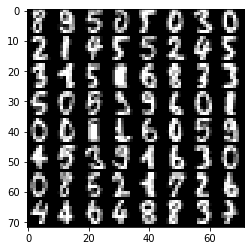

In [79]:
# prediction
x.d, t.d = data.next()  # Here we predict images from training set although it's useless. 
y.forward()  # You can execute a sub graph.
plt.imshow(tile_images(x.d), **imshow_opt)
print("prediction:")
print(y.d.argmax(axis=1).reshape(8, 8))  # Taking a class index based on prediction score.

### save model

In [80]:
def save_nnp(input, output, batchsize):
    runtime_contents = {
        'networks': [
            {'name': 'Validation',
             'batch_size': batchsize,
             'outputs': output,
             'names': input}],
        'executors': [
            {'name': 'Runtime',
             'network': 'Validation',
             'data': [k for k, _ in input.items()],
             'output':[k for k, _ in output.items()]}]}
    return runtime_contents

In [81]:
# save parameters
nn.save_parameters(h5_file_name)

2020-04-20 10:31:57,871 [nnabla][INFO]: Parameter save (.h5): static_graph.h5


In [82]:
img = nn.Variable(x.shape)
lab = nn.Variable(t.shape)
img.d, lab.d = data.next()
if CNN_GRAPH == 0:
    content = save_nnp(input={'x': x}, output={'y': y, 'loss': loss, 't': t}, batchsize=batch_size)
elif CNN_GRAPH == 1:
    content = save_nnp(input={'x': x}, output={'y': y, 'y0': y0, 'y1': y1, 'loss': loss, 't': t}, batchsize=batch_size)
print(content)

{'networks': [{'name': 'Validation', 'batch_size': 64, 'outputs': {'y': <Variable((64, 10), need_grad=True) at 0x7face6d26548>, 'y0': <Variable((64, 64, 4, 4), need_grad=True) at 0x7facea486598>, 'y1': <Variable((64, 64, 4, 4), need_grad=True) at 0x7facea48c458>, 'loss': <Variable((), need_grad=True) at 0x7facea3cf2c8>, 't': <Variable((64, 1), need_grad=False) at 0x7face744fcc8>}, 'names': {'x': <Variable((64, 1, 8, 8), need_grad=False) at 0x7face744f778>}}], 'executors': [{'name': 'Runtime', 'network': 'Validation', 'data': ['x'], 'output': ['y', 'y0', 'y1', 'loss', 't']}]}


In [83]:
import nnabla.utils.save as save
save.save(nnp_file_name, content)

2020-04-20 10:31:57,894 [nnabla][INFO]: Saving cnn_static_graph.nnp as nnp
2020-04-20 10:31:57,895 [nnabla][INFO]: Saving /tmp/tmph7r2cnyu/network.nntxt as prototxt
2020-04-20 10:31:57,899 [nnabla][INFO]: Parameter save (.protobuf): /tmp/tmph7r2cnyu/parameter.protobuf


### load model

In [84]:
from nnabla.utils.nnp_graph import NnpLoader

# load h5
nn.load_parameters(h5_file_name)
# Read a .nnp file.
nnp = NnpLoader(nnp_file_name)

In [85]:
nw_name = nnp.get_network_names()[0]
net = nnp.get_network(nw_name)

In [86]:
net.variables

{'x': <Variable((64, 1, 8, 8), need_grad=False) at 0x7face6c370e8>,
 'affine1/conv1/conv/W': <Variable((64, 1, 3, 3), need_grad=True) at 0x7face6c32188>,
 'y0': <Variable((64, 64, 4, 4), need_grad=True) at 0x7face6c320e8>,
 'y1': <Variable((64, 64, 4, 4), need_grad=True) at 0x7face6c32048>,
 'affine1/affine/W': <Variable((1024, 10), need_grad=True) at 0x7face6c32098>,
 'affine1/affine/b': <Variable((10,), need_grad=True) at 0x7facea249868>,
 'y': <Variable((64, 10), need_grad=True) at 0x7facea327908>,
 't': <Variable((64, 1), need_grad=False) at 0x7facea284db8>,
 'SoftmaxCrossEntropy_Output': <Variable((64, 1), need_grad=True) at 0x7facea249638>,
 'loss': <Variable((), need_grad=True) at 0x7facea2491d8>}

In [87]:
nw_name = nnp.get_network_names()[0]
print('nw_name = %s' % nw_name)
net = nnp.get_network(nw_name)
print(net)
# load h5
nn.load_parameters(h5_file_name)

nw_name = Validation


In [88]:
print(net.inputs)
print(net.outputs)

{'x': <Variable((64, 1, 8, 8), need_grad=False) at 0x7facea249778>, 't': <Variable((64, 1), need_grad=False) at 0x7facea249728>}
{'loss': <Variable((), need_grad=True) at 0x7face71eb1d8>}


In [89]:
x = net.inputs['x']
y = net.outputs['y']
print(x)
print(y)

KeyError: 'y'

data.position=1361
prediction:
[[8 9 5 0 5 0 3 0]
 [2 1 7 5 5 2 4 5]
 [3 1 5 1 6 8 7 3]
 [5 0 5 9 9 1 0 1]
 [0 0 1 1 6 6 5 9]
 [4 5 3 9 1 6 3 0]
 [0 8 5 2 1 7 2 6]
 [4 4 6 4 8 8 3 7]]


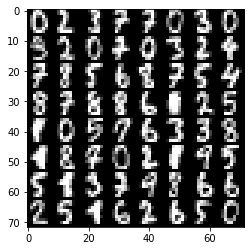

In [90]:
# prediction
print('data.position=%d' % data.position)
x.d, _ = data.next()  # Here we predict images from training set although it's useless. 
y.forward()  # You can execute a sub graph.
plt.imshow(tile_images(x.d), **imshow_opt)
print("prediction:")
print(y.d.argmax(axis=1).reshape(8, 8))  # Taking a class index based on prediction score.

### File format conversion
Convert from NNP to NNB

In [91]:
import subprocess, sys
out = subprocess.Popen(['nnabla_cli', 'convert', nnp_file_name, nnb_file_name])